In [1]:
# Dependencies
import pandas as pd
from scipy.io import loadmat
import glob
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import LSTM,Dropout,Dense 
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F


## Step 1: Load the data.
Class has 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

In [11]:
# folder names
dc_folders = ['Europe', 'Japan', 'USA']

# Implement the dataset class
class DrivingCyclesDataset(Dataset):
    def __init__(self,
                 path_to_dc,
                 idxs_train,
                 idxs_test,
                 train=True):
        # path_to_dc: where you put the driving cycles dataset
        # idxs_train: training set indexes
        # idxs_test: test set indexes
        # train: return training set or test set
        
        # Load all the driving cycles
        alldata = []
        dcnames = []
        mat = loadmat('./DrivingCycles/WLTPextended.mat')
        df = pd.DataFrame(mat['V_z'], columns = ['V_z']) # velocity 
        df2 = pd.DataFrame(mat['T_z'], columns = ['T_z']) # time
        df3 = pd.DataFrame(mat['D_z'], columns = ['D_z']) # acceleration
        df = pd.concat([df, df2, df3], axis=1)
        alldata.append(df)
        dcnames.append('WLTPextended.mat')
        for folder in dc_folders:
            image_path = os.path.join(path_to_dc, folder)
            files = glob.glob(image_path + '/*.mat')
            for f in files:
                mat = loadmat(f)
                df = pd.DataFrame(mat['V_z'], columns = ['V_z'])
                df2 = pd.DataFrame(mat['T_z'], columns = ['T_z'])
                df3 = pd.DataFrame(mat['D_z'], columns = ['D_z'])
                df = pd.concat([df, df2, df3], axis=1)
                dcnames.append(os.path.basename(f))
                # each dataframe is a driving cycle 
                alldata.append(df)

        # Extract the driving cycles with the specified file indexes     
        alldata_np = (np.array(alldata, dtype=object))[p] #numpy array of dataframes 
        dcnames_np = (np.array(dcnames, dtype=object))[p]
        if train==True:
            self.data = np.concatenate([alldata_np[:idxs_test], alldata_np[idxs_test+1:]])
            self.names = np.concatenate([dcnames_np[:idxs_test], dcnames_np[idxs_test+1:]])
        else:
            self.data = alldata_np[idxs_test:idxs_test+1]
            self.names = dcnames_np[idxs_test:idxs_test+1]


    def __len__(self, idx):
        # Return the number of samples in a driving cycle 
        return (self.data[idx]).size
        
    def __getitem__(self, idx):
        # Get an item using its index
        # Return the driving cycle and its name 
        return self.data[idx]

In [12]:
def split_train_test(lendata, percentage=0.8):
    idxs_train = int(percentage * lendata)
    idxs_test = idxs_train + 1 
    return idxs_train, idxs_test

LENDATA = 36 + 6 + 4 + 1 # number of driving cycles = 47
np.random.seed(42)
idxs_train, idxs_test = split_train_test(LENDATA,0.8)
idxs_test = 22 # only 1 test driving cycle for easier visualisation
p = np.random.permutation(int(LENDATA))

In [13]:
def create_dataset(dataset, h, f, step):
    x = [] #append the last 50 values
    y = [] #append the future value 
    for df in dataset:
        features_considered = ['V_z', 'D_z']
        features = df[features_considered]
        for i in range(h, df.shape[0]):
            # for each driving cycle dataframe, have sets of 51 values 
            # h values are past values, f values are future value 
            x.append(features[i-h:i:step])
            # y.append(df.loc[i:i+f, "V_z"])
            y.append(df.loc[i, "V_z"])
    x = np.array(x) 
    y = np.array(y)  
    # y = np.asarray(y).astype(np.float32)
    return x,y

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

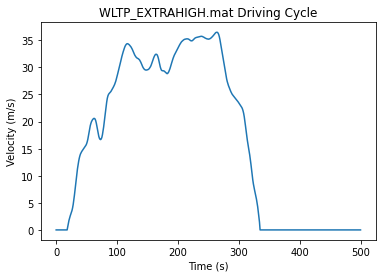

In [19]:
# loading datasets
dc_path = './DrivingCycles/'
dataset_train  = DrivingCyclesDataset(dc_path, idxs_train, idxs_test, train=True)
dataset_test = DrivingCyclesDataset(dc_path, idxs_train, idxs_test, train=False)

# # Plot samples from the test set
# # Europe NEDC 
# sample_data = dataset_train.data[26]
# sample_name = dataset_train.names[26]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# # Europe WLTP 
# sample_data = dataset_train.data[37]
# sample_name = dataset_train.names[37]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# # Japan 10 Mode 
# sample_data = dataset_train.data[30]
# sample_name = dataset_train.names[30]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# # US FTP_75 
# sample_data = dataset_train.data[17]
# sample_name = dataset_train.names[17]
# print(sample_data.describe())
# plt.title(sample_name + " Driving Cycle")
# plt.xlabel("Time (s)")
# plt.ylabel("Velocity (m/s)")
# plt.plot(sample_data['T_z'], sample_data['V_z'])
# plt.show()

# Plot 1 sample from the test set
sample_data = dataset_test.data[0]
sample_name = dataset_test.names[0]
plt.title(sample_name + " Driving Cycle")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.plot(sample_data['T_z'], sample_data['V_z'])
plt.show()

# scaling the datasets 
scaler = MinMaxScaler(feature_range=(0,1))
for df in dataset_train: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    df['D_z'] = scaler.fit_transform(df[['D_z']])
for df in dataset_test: 
    df['V_z'] = scaler.fit_transform(df[['V_z']])
    df['D_z'] = scaler.fit_transform(df[['D_z']])

# parameters h and f
h = 10 # length of historical sequence
f = 10 # length of forecast sequence 
step = 1

# create training set and test set 
x_train, y_train = create_dataset(dataset_train, h, f, step)
x_test, y_test = create_dataset(dataset_test, h, f, step)

# reshaping input to LSTM model 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

# reshaping output 
# y_train = np.expand_dims(y_train, -1)
# y_test = np.expand_dims(y_test, -1)
# y_train = np.asarray(y_train).astype(np.float32)
# y_test = np.asarray(y_train).astype(np.float32)

## Step 3: LSTM
In this section we will try to make a LSTM predictor to predict the future velocity. 

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [20]:
# check
print(x_train.shape)
print(y_test.shape)

# Network 
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) # units depends on create_dataset function
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=f))

(134407, 10, 2)
(491,)


### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [21]:
# compile the model 
model.compile(loss='mse', optimizer='adam')

### Step 3.3: Train the model. (15 points)

Complete the training loop.

In [22]:
model.fit(x_train, y_train, epochs=10, batch_size=50)
model.save('speed_prediction.h5')

# load the model 
model = load_model('speed_prediction.h5') 

Epoch 1/10
 276/2689 [==>...........................] - ETA: 3:09 - loss: 0.0162

### Step 3.4: Deploy the trained model onto the test set. 

In [10]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))
print(y_test_scaled.shape)
print(predictions.shape)

ValueError: setting an array element with a sequence.

### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

Text(0, 0.5, 'Time (s)')

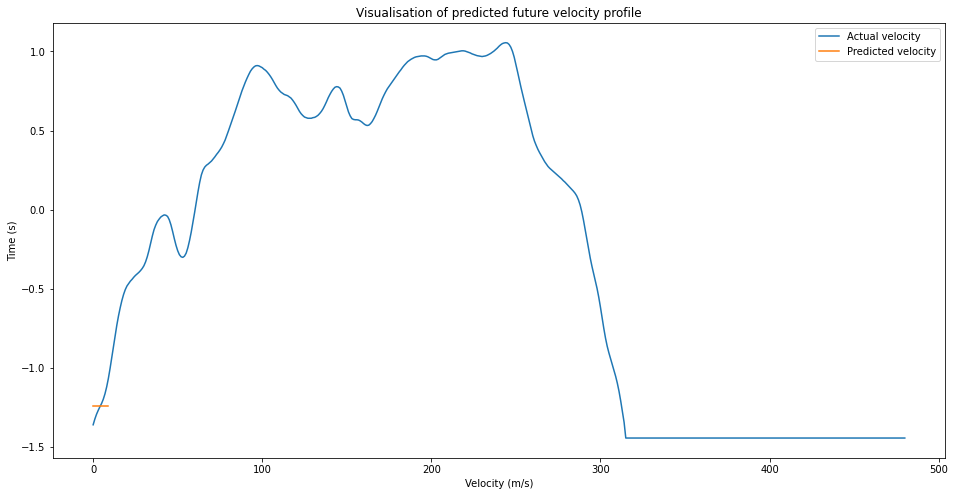

In [34]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test_scaled, label='Actual velocity')
plt.plot(predictions[4], label='Predicted velocity')
plt.legend()
plt.title('Visualisation of predicted future velocity profile')
plt.xlabel("Velocity (m/s)")
plt.ylabel("Time (s)")